# Analýza kandidátů do Poslanecké sněmovny napříč roky
## Úvod
V dané práci se budeme zabývat analýzou dat o kandidátech do Poslanecké sněmovny od roku 2006. Hlavním zdrojem jsou [data z Českého statistického úřadu](https://volby.cz/opendata/opendata.htm).
* Během analýzy budeme chtít odpovědět na následující otázky:
    *  Jaké je věkové rozložení kandidátů v jednotlivých rocích?
    *  Jak velké zastoupení mají muži a ženy?
    *  Jaká ideologie převládá?
    *  Jaké obory jsou u kandidátů nejčastější?
    *  Jaký vliv má vysokoškolské vzdělání na volbu ideologii kandidátem?

Navíc natrénujeme binární klasifikační model, který bude predikovat, zda kandidát dostane mandát nebo ne na základě dostupných prvků.

In [16]:
# Installations
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn

## Import knihoven a inicializace potřebných funkcí
Pro danou práci budou použité knihovny pandas a numpy pro manipulaci s daty, matplotlib a seaborn pro vizualizaci a sci-kit learn pro účely strojového učení. Knihovna warnings je tady za účelem skrytí upozornění buněk.

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# filtrace upozornění
warnings.filterwarnings("ignore")
# nastavení standardního rozměru grafu
# plt.rc("figure", figsize=(10, 6))
plt.rcParams["figure.figsize"] = (15, 9)

Následující buňka zavádí funkci "obor", která mapuje příslušné obory (finance, právo, politika, řemeslo) na základě povolání jednotlivých kandidátů. Pro danou úlohu je potřeba předem definovaný slovník, který máme udělaný pomocí nejčastějších klíčových slov ve sloupci POVOLANI

In [82]:
import json # daná knihovna umožňuje snadný import JSON souborů ve formatu python slovníků

with open("dict_occupations.json", "r", encoding="utf-8") as file: # otevření JSON souboru
    occup_dict = json.load(file)


def obor(val: str) -> str:
    """
    Checks to what field does candidate's profession belongs to (such as finance, law, medicine etc.) with the help of keywords from global occup_dict dictionary
    :param val: string value containing candidate's profession description
    :return: string value with the particular field, returns "Jiné" if no matches were found
    """
    global occup_dict
    for key in occup_dict.keys():
        for i in occup_dict[key]["var"]:
            if i in val.lower():
                return occup_dict[key]["name"]
    return "jiné"


occup_dict.keys()

dict_keys(['duchod', 'podnik', 'zivnost', 'remeslo', 'soukzam', 'finance', 'student', 'akademik', 'statzam', 'zdravotnictvi', 'politik', 'nezam', 'manager', 'zemedel', 'pravo', 'odbor', 'umeni', 'sport'])

Jelikož máme volební data z vícera let, které mají více či méně standardizovaný tvar, je výhodné použít jednu předem definovanou funkci na čištění všech datových souborů.

In [83]:
def clean_data(data: pd.DataFrame, strany: dict) -> pd.DataFrame:
    """
    Clean and prepare a dataframe containing data from different types of elections for further visualisation and modelling purposes.
    The output is:
        -[cele_jmeno]: combining name columns into one
        -[vek]: candidate's age
        -[vs_vzdelani]: Creating a boolean column checking whether a candidate has university degree
        -[obor]: field of candidate's profession
        -[pohlavi]: candidate's gender (based on their surname's ending)
        -[kraj]: region where candidate runs their campaign
        -[NSTRANA]: political party that nominated the candidate
        -[ideologie]: canidate's ideology (left-wing, center, right-wing)
        -[mandat]: whether candidate got their mandate
        -[year]: year of elections
    :param data: pandas dataframe including elections data
    :param strany: dictionary data type with political parties' data
    :return: cleaned pandas dataframe
    """
    df = data.copy()

    df["cele_jmeno"] = df["JMENO"] + " " + df["PRIJMENI"]
    df["pohlavi"] = np.where(df.loc[:, "cele_jmeno"].str[-1] == "á", "F", "M")
    df["vs_vzdelani"] = np.where((df["TITULPRED"].notnull()) | (df["TITULZA"].notnull()), 1, 0)
    df["vek"] = df["VEK"]

    # seznam krajů dle kódů
    kraj_list = ["Hlavní město Praha", "Středočeský kraj", "Jihočeský kraj", "Plzeňský kraj", "Karlovarský kraj",
                "Ústecký kraj", "Liberecký kraj", "Královéhradecký kraj", "Pardubický kraj", "Kraj Vysočina",
                "Jihomoravský kraj", "Olomoucký kraj", "Zlínský kraj", "Moravskoslezský kraj"]
    kraj_dict = dict(zip(list(range(1, 15)), kraj_list))
    df["ideologie"] = df["NSTRANA"].map(strany)
    df["kraj"] = df["VOLKRAJ"].map(kraj_dict)
    df["obor"] = df["POVOLANI"].apply(lambda row: obor(str(row))) # mapuje slovník oborů na sloupec "POVOLANI"
    df["mandat"] = df["MANDAT"].apply(lambda row: 1 if str(row) == "A" or str(row) == "1" else 0) # převádí různé záznamy na jeden tvar (v některých letech je to A/N, někde 1/0)
    columns = ["cele_jmeno", "vek", "vs_vzdelani", "obor", "pohlavi", "kraj", "NSTRANA", "ideologie", "mandat", "year"]

    return df[columns]

## Načítání dat
Popis některých ze sloupců, které budou v koncovém souboru:
   * VOLKRAJ - číslo kraje, na základě těchto čísel budou navázány názvy krajů
   * JMENO, PRIJMENI - jméno a příjmení, na základě koncovky u příjmení se vytvoří sloupec "pohlavi"
   * TITULPRED, TITULZA - tituly před a za jménem, při přitomnosti aspoň jedné ze dvou se sloupci "vs_vzdelani" přířadí hodnota 1, jinak 0
   * VEK - věk
   * POVOLANI - povolaní kandidáta, je nutné dodat, že toto políčko kandidáti vyplňovali sámi a proto v tom je hodně záznamů, které nemají žádný standard. Sloupec "obor" v koncovém souboru vznikne na základě klíčových slov ze sloupce POVOLANI.
   * NSTRANA - strána, která kandidáta navrhla, ze všech sloupců se strany byl použit tento, jelikož je to jediný, kde bylo nejméně chybějících hodnot z toho důvodů, že každého kandidáta musela navrhnout jakási strana vždycky na rozdíl od např. KSTRANA, která označuje stránu kandidáta, kde on může být i beze strány. Hlavní účel tohoto sloupce pro nás je **ideologie**, která pomáhá se tříděním kandidátů do uzčích skupin
   * MANDAT - zda kandidát nakonec dostal mandát nebo ne
   * year - rok voleb, byl přídan během načítání dat

In [20]:
# data budou staženy do listu snem_list
snem_list = []
snem_years = [2006, 2010, 2013, 2017, 2021] # jednotlivé roky voleb
for year in snem_years:
    temp_df = pd.read_csv(f"legislative-elections/snem_{year}.csv",
                          sep=";", encoding="utf-8")
    temp_df["year"] = year
    snem_list.append(temp_df)

snem_list[0].head(10)

,VOLKRAJ,KSTRANA,PORCISLO,JMENO,PRIJMENI,TITULPRED,TITULZA,VEK,POVOLANI,BYDLISTEN,...,NSTRANA,PLATNOST,POCHLASU,POCPROC,POCPROCVSE,MANDAT,PORADIMAND,PORADINAHR,CPU,year
0,14,6,1,František,Zwyrtek,NaN,NaN,45,předseda hnutí,Český Těšín,...,88,0,120,0.0,2.86,0,0,0,NaN,2006
1,14,6,2,Vladimír,Mach,RNDr.,NaN,63,středoškolský profesor,Havířov,...,88,0,93,0.0,2.21,0,0,0,NaN,2006
2,14,6,3,Zdeněk,Stolař,PhDr.,NaN,51,psycholog,Frýdek-Místek,...,88,0,137,0.0,3.26,0,0,0,NaN,2006
3,14,6,4,Alena,Hasáková,PhDr.,NaN,51,středoškolský profesor,Český Těšín,...,88,0,124,0.0,2.95,0,0,0,NaN,2006
4,14,6,5,Alois,Čtvrtníček,Ing.,CSc.,60,podnikatel,Bruntál,...,88,0,35,0.0,0.83,0,0,0,NaN,2006
5,14,6,6,Hana,Doležalová,Mgr.,NaN,33,učitelka,Ostrava,...,88,0,81,0.0,1.93,0,0,0,NaN,2006
6,14,6,7,Václav,Kafka,Doc. Ing.,CSc.,63,výzkumný pracovník,Orlová,...,88,0,76,0.0,1.81,0,0,0,NaN,2006
7,14,6,8,Libuše,Koppová,NaN,NaN,59,zdravotní sestra,Třinec,...,88,0,95,0.0,2.26,0,0,0,NaN,2006
8,14,6,9,Alexander,Nedbálek,MUDr.,NaN,51,lékař,Havířov,...,88,0,48,0.0,1.14,0,0,0,NaN,2006
9,14,6,10,Jan,Fismol,Bc.,NaN,59,místostarosta,Dolní Lutyně,...,88,0,56,0.0,1.33,0,0,0,NaN,2006


Následující dataframe obsahuje data o stranách, které se zúčastnily voleb do sněmovny v rocích 2006 - 2021. Sloupec **Ideologie** byl přidan ručně na základě veřejně dostupných informací ohledně každé strany.

In [21]:
strany = pd.read_csv("legislative-elections/strany.csv",
                    sep=";", encoding="utf-8")
strany_dict = dict(zip(strany["VSTRANA"], strany["Ideologie"]))
strany.head()

,VSTRANA,NAZEVCELK,ZKRATKAK8,Ideologie
0,1,Křesťanská a demokratická unie - Československ...,KDU-ČSL,Střed
1,2,Česká strana národně sociální,ČSNS,Levice
2,5,Strana zelených,SZ,Levice
3,7,Česká strana sociálně demokratická,ČSSD,Levice
4,11,Sdružení pro republiku-Republikánská strana Če...,SPR-RSČ,Pravice


Sloupec "pohlavi" byl vytvořen na základě koncovky příjmení kandidáta.

In [84]:
# Čištění dat pomocí funkce clean_data
snem_clean_list = []

for i in range(5):
    temp_df = clean_data(snem_list[i], strany_dict)
    snem_clean_list.append(temp_df)

snem_clean_list[0].head(10)

,cele_jmeno,vek,vs_vzdelani,obor,pohlavi,kraj,NSTRANA,ideologie,mandat,year
0,František Zwyrtek,45,0,management,M,Moravskoslezský kraj,88,Střed,0,2006
1,Vladimír Mach,63,1,státní zaměstnanec,M,Moravskoslezský kraj,88,Střed,0,2006
2,Zdeněk Stolař,51,1,zdravotnictví,M,Moravskoslezský kraj,88,Střed,0,2006
3,Alena Hasáková,51,1,státní zaměstnanec,F,Moravskoslezský kraj,88,Střed,0,2006
4,Alois Čtvrtníček,60,1,podnikání,M,Moravskoslezský kraj,88,Střed,0,2006
5,Hana Doležalová,33,1,státní zaměstnanec,F,Moravskoslezský kraj,88,Střed,0,2006
6,Václav Kafka,63,1,věda,M,Moravskoslezský kraj,88,Střed,0,2006
7,Libuše Koppová,59,0,zdravotnictví,F,Moravskoslezský kraj,88,Střed,0,2006
8,Alexander Nedbálek,51,1,zdravotnictví,M,Moravskoslezský kraj,88,Střed,0,2006
9,Jan Fismol,59,1,politika,M,Moravskoslezský kraj,88,Střed,0,2006


In [85]:
# v dané buňce dáváme veškeré dataframy do jednoho, jelikož pro budoucí účely potřebujeme data ve formatu long
snem_long = pd.concat(snem_clean_list, ignore_index=True)
snem_long.tail(10)

,cele_jmeno,vek,vs_vzdelani,obor,pohlavi,kraj,NSTRANA,ideologie,mandat,year
28768,Michal Havlík,42.0,0,podnikání,M,Moravskoslezský kraj,83.0,Pravice,0,2021
28769,Michaela Hanzlík Skarabellová,51.0,0,management,F,Moravskoslezský kraj,83.0,Pravice,0,2021
28770,Jiří Minařík,51.0,0,management,M,Moravskoslezský kraj,83.0,Pravice,0,2021
28771,Vladimír Herout,62.0,0,státní zaměstnanec,M,Moravskoslezský kraj,83.0,Pravice,0,2021
28772,František Kolínek,43.0,0,soukromý sektor,M,Moravskoslezský kraj,83.0,Pravice,0,2021
28773,Roman Zvoníček,46.0,0,soukromý sektor,M,Moravskoslezský kraj,83.0,Pravice,0,2021
28774,Tomáš Kleibl,25.0,0,řemeslo,M,Moravskoslezský kraj,83.0,Pravice,0,2021
28775,Alois Nezbeda,77.0,0,řemeslo,M,Moravskoslezský kraj,83.0,Pravice,0,2021
28776,Jiří Žváček,58.0,0,řemeslo,M,Moravskoslezský kraj,83.0,Pravice,0,2021
28777,Petr Srovnal,61.0,0,soukromý sektor,M,Moravskoslezský kraj,83.0,Pravice,0,2021


## Ošetření chybějících hodnot
Nejdříve musíme zkontrolovat, zda máme všechna data a nechybí-li nám něco

In [24]:
print("Počet chybějících hodnot v každém sloupci:\n")
print(snem_long.isnull().sum())
print("-" * 40)
print("Nejčastější ideologie kandidátů:\n")
print(snem_long["ideologie"].value_counts())

Počet chybějících hodnot v každém sloupci:

cele_jmeno       0
vek             11
vs_vzdelani      0
obor             0
pohlavi          0
kraj             0
NSTRANA         11
ideologie      214
mandat           0
year             0
dtype: int64
----------------------------------------
Nejčastější ideologie kandidátů:

Pravice    14370
Levice      7505
Střed       6689
Name: ideologie, dtype: int64


Jak je zřejmé z výstupu nahoře, máme chybějící hodnoty ve sloupcích vek, NSTRANA a ideologie.
Nejčastější ideologie je pravicová. Tím pádem bez ztráty informace bychom mohli zaměnit NA hodnoty danou ideologií.
NA hodnoty ve sloupcích vek a NSTRANA jsou neexistujícími kandidáty, takže je můžeme klidně odstranit.

In [25]:
snem_long[snem_long["vek"].isnull()]

,cele_jmeno,vek,vs_vzdelani,obor,pohlavi,kraj,NSTRANA,ideologie,mandat,year
6689,Registrační úřad ponechal pozici volnou Kandid...,NaN,0,Jiné,M,Zlínský kraj,NaN,NaN,0,2010
8151,Registrační úřad ponechal pozici volnou Kandid...,NaN,0,Jiné,M,Ústecký kraj,NaN,NaN,0,2010
8153,Registrační úřad ponechal pozici volnou Kandid...,NaN,0,Jiné,M,Ústecký kraj,NaN,NaN,0,2010
8423,Registrační úřad ponechal pozici volnou Kandid...,NaN,0,Jiné,M,Ústecký kraj,NaN,NaN,0,2010
8427,Registrační úřad ponechal pozici volnou Kandid...,NaN,0,Jiné,M,Ústecký kraj,NaN,NaN,0,2010
14145,Registrační úřad ponechal pozici volnou Kandid...,NaN,0,Jiné,M,Jihočeský kraj,NaN,NaN,0,2013
22308,Registrační úřad ponechal pozici volnou Kandid...,NaN,0,Jiné,M,Zlínský kraj,NaN,NaN,0,2017
25605,Registrační úřad ponechal pozici volnou Kandid...,NaN,0,Jiné,M,Ústecký kraj,NaN,NaN,0,2021
25671,Registrační úřad ponechal pozici volnou Kandid...,NaN,0,Jiné,M,Ústecký kraj,NaN,NaN,0,2021
26775,Registrační úřad ponechal pozici volnou Kandid...,NaN,0,Jiné,M,Kraj Vysočina,NaN,NaN,0,2021


In [86]:
# Veškeré NA hodnoty ve sloupci ideologie budou přiřazeny pravicové ideologie, jelikož je nejčastější

snem_long = snem_long.dropna(subset=["vek"])
snem_long.ideologie = snem_long.ideologie.fillna("Pravice")

print("Stav po ošetření chybějících hodnot:")
print("Počet chybějících hodnot v každém sloupci:\n")
print(snem_long.isnull().sum())
print("-" * 40)
print("Nejčastější ideologie kandidátů:\n")
print(snem_long["ideologie"].value_counts())

Stav po ošetření chybějících hodnot:
Počet chybějících hodnot v každém sloupci:

cele_jmeno     0
vek            0
vs_vzdelani    0
obor           0
pohlavi        0
kraj           0
NSTRANA        0
ideologie      0
mandat         0
year           0
dtype: int64
----------------------------------------
Nejčastější ideologie kandidátů:

Pravice    14573
Levice      7505
Střed       6689
Name: ideologie, dtype: int64


## Exploratorní analýza
Další částí této úlohy bude exploratorní datová analýza.
Jako první se budeme muset podívat na datové typy jednotlivých sloupců:

In [27]:
snem_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28767 entries, 0 to 28777
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cele_jmeno   28767 non-null  object 
 1   vek          28767 non-null  float64
 2   vs_vzdelani  28767 non-null  int32  
 3   obor         28767 non-null  object 
 4   pohlavi      28767 non-null  object 
 5   kraj         28767 non-null  object 
 6   NSTRANA      28767 non-null  float64
 7   ideologie    28767 non-null  object 
 8   mandat       28767 non-null  int64  
 9   year         28767 non-null  int64  
dtypes: float64(2), int32(1), int64(2), object(5)
memory usage: 2.3+ MB


Všechny kategoriální sloupce převedeme na příslušný datový typ, proměnná věk bude integerem.
Tímto nám vzniká situace, když máme většinu proměnných kategoriální, což může způsobit větší počet dimenzí při trénování modelů.

In [28]:
for col in ["vs_vzdelani", "obor", "pohlavi", "kraj", "NSTRANA", "ideologie", "mandat", "year"]:
    snem_long[col] = snem_long[col].astype("category")

snem_long["vek"] = snem_long["vek"].astype("int64")

snem_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28767 entries, 0 to 28777
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   cele_jmeno   28767 non-null  object  
 1   vek          28767 non-null  int64   
 2   vs_vzdelani  28767 non-null  category
 3   obor         28767 non-null  category
 4   pohlavi      28767 non-null  category
 5   kraj         28767 non-null  category
 6   NSTRANA      28767 non-null  category
 7   ideologie    28767 non-null  category
 8   mandat       28767 non-null  category
 9   year         28767 non-null  category
dtypes: category(8), int64(1), object(1)
memory usage: 903.7+ KB


První vizualizace bude rozložení věků kandidátů podle pohlaví v jednotlivých rocích, navíc označíme míry centrální tendence na každém grafu.

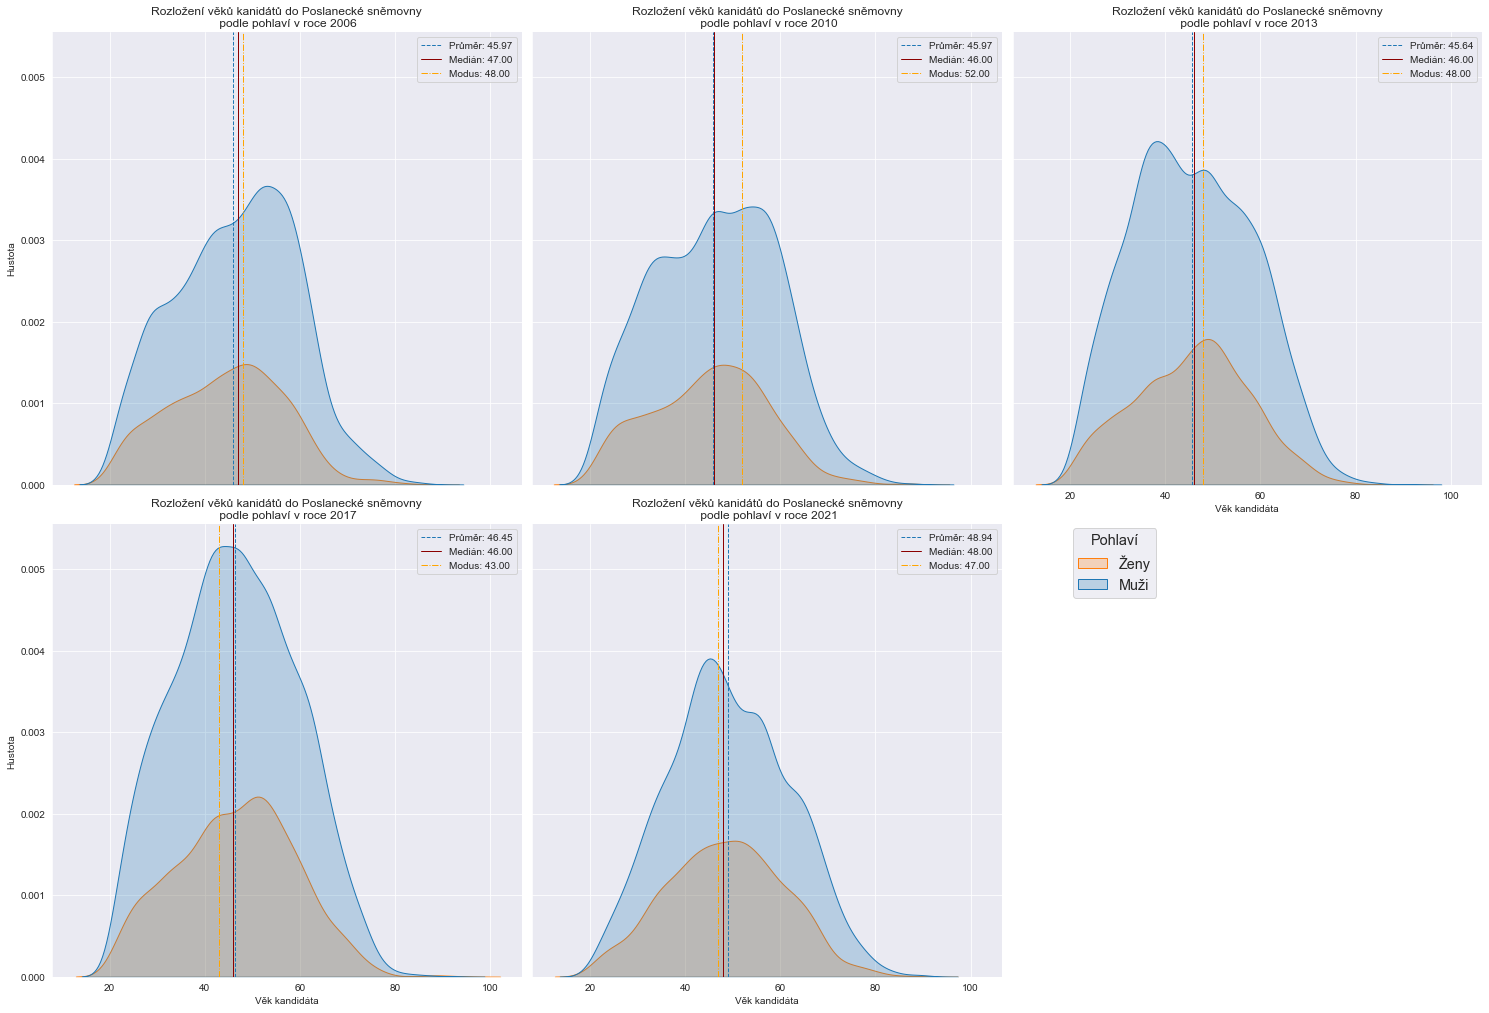

In [133]:
# knihovna seaborn a distribution plot budou použity pro daný účel, každý rok bude mít svůj graf
g = sns.displot(
        data=snem_long, x="vek", hue="pohlavi", kind="kde",
        fill=True, legend=True, col="year", col_wrap=3,
        height=7
    )
g.set_titles("Rozložení věků kanidátů do Poslanecké sněmovny\n podle pohlaví v roce {col_name}",
             size="large")
g.set(xlabel="Věk kandidáta", ylabel="Hustota")
sns.move_legend(g, "center right", bbox_to_anchor=(.75, .45), frameon=True, fontsize="x-large",
                title="Pohlaví", title_fontsize="x-large", labels=["Ženy", "Muži"])

# také na grafech budou označeny míry centrální tendence ve tvaru svislých přímek
years_avgs = {}
for i, year in enumerate(snem_years):
    years_avgs[i] = [snem_long.query(f"year == {year}")["vek"].mean(),
                     snem_long.query(f"year == {year}")["vek"].median(),
                     snem_long.query(f"year == {year}")["vek"].mode().iat[0]]

# nakonec přidáváme přímky na jednotlivé grafy rozložení
axes = g.axes.flatten()
for i, ax in enumerate(axes):
    ax.axvline(years_avgs[i][0], ls="--", lw=1.0, label=f"""Průměr: {years_avgs[i][0]:.2f}""")
    ax.axvline(years_avgs[i][1], color="darkred", lw=1.0, label=f"""Medián: {years_avgs[i][1]:.2f}""")
    ax.axvline(years_avgs[i][2], ls="-.", color="orange", lw=1.0, label=f"""Modus: {years_avgs[i][2]:.2f}""")
    ax.legend(loc=0)

Podle výstupu můžeme usoudit, že poměr mužů a žen je u většiny věkových skupin 2-2,5 ku 1. Mužů se totiž kandiduje víc.
Rozdělení jsou špičaté, ale symetrické kolem 47 let, jak nám to ukazují průměry a mediány. Můžeme říct, že u voleb do poslanecké sněmovny nedochází k nerovnoměrnému rozdělení věků a žádná věková skupina nepřevládá.
Teď se podívejme na míry centrální tendence věku u každé ideologie zvlášť:

In [30]:
snem_long.groupby("ideologie").vek.describe()

,count,mean,std,min,25%,50%,75%,max
ideologie,,,,,,,,
Levice,7505.0,47.353764,12.571288,21.0,38.0,48.0,57.0,90.0
Pravice,14573.0,46.424209,12.958917,21.0,37.0,46.0,56.0,94.0
Střed,6689.0,46.012408,11.723246,21.0,37.0,46.0,55.0,84.0


Z tabulky je zřejmé, že každá skupina zastupena rovnoměrně a moc se od ostatních neliší.
Druhým grafem bude porovnání ideologií kandidátů podle krajů u voleb v roce 2021 a také se podíváme, jaké zastupitelstvo mají ideologie ve sněmovně:

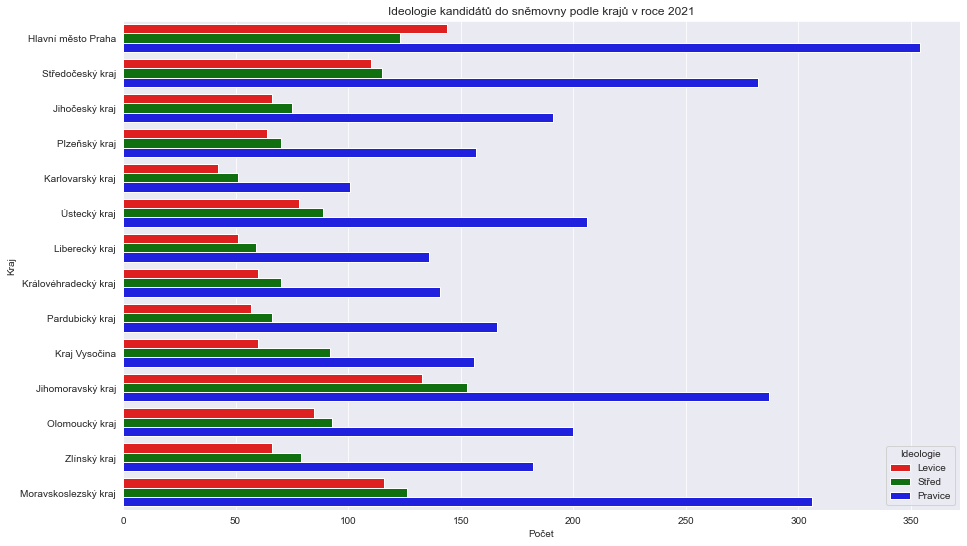

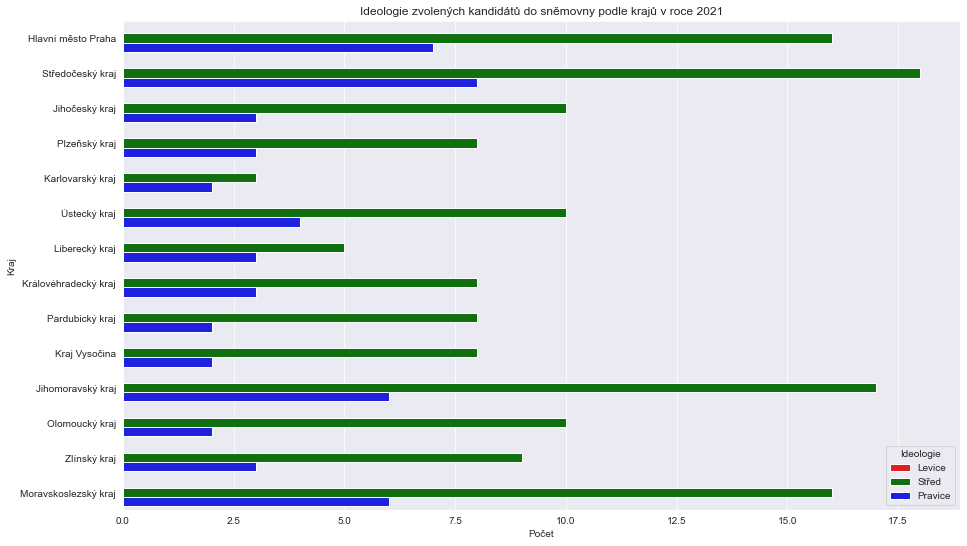

In [99]:
# pořadí tříd a příslušných barev
hue_order = ["Levice", "Střed", "Pravice"]
hue_palette = ["Red", "Green", "Blue"]

# první graf
sns.countplot(snem_clean_list[4], y="kraj", hue="ideologie",
              hue_order=hue_order, palette=hue_palette)
plt.title("Ideologie kandidátů do sněmovny podle krajů v roce 2021")
plt.xlabel("Počet")
plt.ylabel("Kraj")
plt.legend(title="Ideologie")
plt.show()

# druhý graf
sns.countplot(snem_clean_list[4][snem_clean_list[4]["mandat"] == 1], y="kraj", hue="ideologie",
              hue_order=hue_order, palette=hue_palette)
plt.title("Ideologie zvolených kandidátů do sněmovny podle krajů v roce 2021")
plt.xlabel("Počet")
plt.ylabel("Kraj")
plt.legend(title="Ideologie")
plt.show();

Vidíme, že pravicové ideologie převládají nejvíc ve všech krajích, ale do sněmovny se nakonec dostávají nejčastěji kandidáti ze středu.
Třetí vizualizací bude počet různých oborů podle VŠ vzdělání.

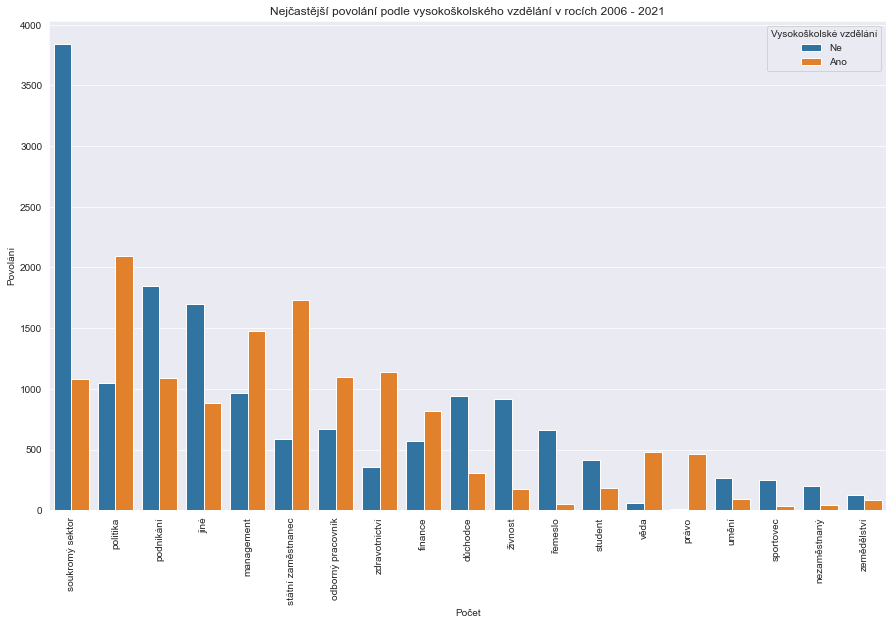

In [105]:
plt.figure(figsize=(15, 9))
g = sns.countplot(
    data=snem_long, x="obor", hue="vs_vzdelani",
    order=snem_long.obor.value_counts().index
)
plt.title("Nejčastější povolání podle vysokoškolského vzdělání v rocích 2006 - 2021")
plt.xlabel("Počet")
plt.xticks(rotation=90)
plt.ylabel("Povolání")
plt.legend(title="Vysokoškolské vzdělání",
           labels=["Ne", "Ano"]);

Nejčastěji do voleb jdou lidé ze soukromého sektoru bez vysokoškolského vzdělání, druhou skupinou jsou již lidé z politiky (např. starostové, hejtmani), kteří většinou vysokou školu za sebou mají, třetí nejčastější skupinu zastupují podnikatelé.
Nakonec se podíváme, zda vzdělání má vliv na volbu ideologii kandidátem:

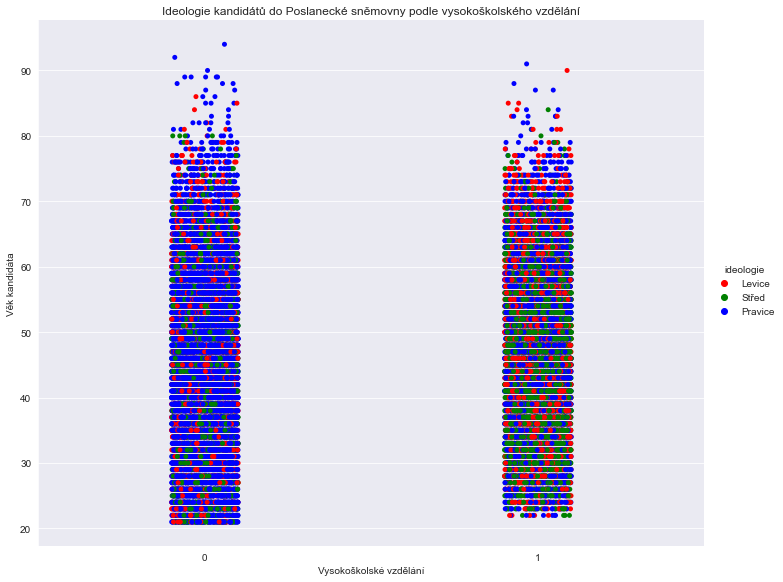

In [93]:
sns.catplot(
    data=snem_long, x="vs_vzdelani", y="vek",
    hue="ideologie", hue_order=hue_order, palette=hue_palette,
    height = 8, aspect = 1.25
)
plt.title("Ideologie kandidátů do Poslanecké sněmovny podle vysokoškolského vzdělání")
plt.xlabel("Vysokoškolské vzdělání")
plt.ylabel("Věk kandidáta");

Kandidáti bez vysokoškolského vzdělání nejčastěji zastupují pravicovou ideologii, zatímco kandidáti se vzděláním jsou více středo-levicové. Avšak podíl levicových kandidátů je značný jen u starších věkových skupin.

## Využití klasifikačního modelu za účelem predikci zvolení kandidáta
Prvním krokem bude tzv. dummifying kategoriálních proměnných, tj. převedeme je na vícedimenzionální tvar

In [34]:
# Dummifying kategoriálních proměnných
snem_ml = snem_long.drop(["cele_jmeno", "NSTRANA", "year"], axis=1) # tyto proměnné nepotřebujeme, jelikož nemají velký vliv na cílovou proměnnou a mají hodně dimenzí
snem_ml = pd.get_dummies(data=snem_ml, columns=["vs_vzdelani", "obor", "pohlavi", "kraj", "ideologie"])
snem_ml.head()

,vek,mandat,vs_vzdelani_0,vs_vzdelani_1,obor_Jiné,obor_důchodce,obor_finančnictví,obor_manažer,obor_nezaměstnaný,obor_odborný pracovník,...,kraj_Moravskoslezský kraj,kraj_Olomoucký kraj,kraj_Pardubický kraj,kraj_Plzeňský kraj,kraj_Středočeský kraj,kraj_Zlínský kraj,kraj_Ústecký kraj,ideologie_Levice,ideologie_Pravice,ideologie_Střed
0,45,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
1,63,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,51,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,51,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,60,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


Jak je zřejmé z grafu níže, cílová proměnná "mandat" je silně nebalancovaná - mandát dostali jen 1000 lidí ze skoro 29 tisíc.

0    27767
1     1000
Name: mandat, dtype: int64


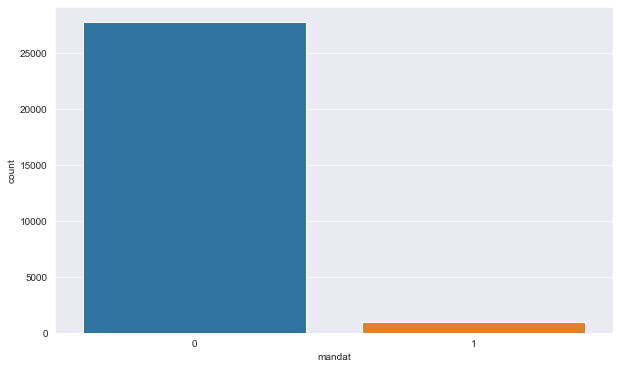

In [71]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=snem_ml, x="mandat"
)
print(snem_ml["mandat"].value_counts())

In [36]:
from sklearn.svm import SVC # Support Vector Machine Classifier algorithm
from sklearn.ensemble import RandomForestClassifier # Random Forest Classifier
from sklearn.preprocessing import StandardScaler # škálování dat
from sklearn.decomposition import PCA # Principal Component Analysis

Metoda undersampling byla zvolena zabránit nevyváženosti dat, tj. náhodně zvolíme stejný počet kandidátů bez mandátu jako je s mandátem.

In [37]:
from sklearn.utils import resample

sn_maj = snem_ml[snem_ml["mandat"] == 0] # rozdělení datasetu na minor/major
sn_min = snem_ml[snem_ml["mandat"] == 1]

sn_maj_und = resample(sn_maj,
                     replace=True,
                     n_samples=1000, # vyrovnání se s minoritní třídou
                     random_state=42)

# dáváme oba sety dohromady a tím to vyvážíme
snem_und = pd.concat([sn_maj_und, sn_min])
print(snem_und["mandat"].value_counts())

0    1000
1    1000
Name: mandat, dtype: int64


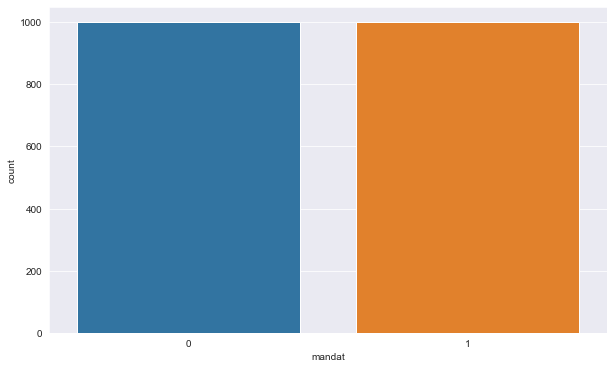

In [72]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=snem_und, x="mandat"
);

Teď cílová proměnná je vyvážená.
Dalším krokem bude rozdělení na testovací a trénovací datasety.

In [39]:
from sklearn.model_selection import train_test_split
# dělení sloupců na prediktory a cílovou proměnnou
predictors = snem_ml.columns.to_list()
predictors.remove("mandat")
target = ["mandat"]

X = snem_und[predictors]
y = snem_und[target]

# dělení dat na trénovací a testovací sety
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f"Rozměr trénovacího datasetu: {len(X_train)}")
print(f"Rozměr testovacího datasetu: {len(X_test)}")

Rozměr trénovacího datasetu: 1500
Rozměr testovacího datasetu: 500


Pro snadnou práci s více modely najednou budou použity pipeliny. V dané časti porovnáme Support Vector Classifier bez preprocessingu a Random Forest Classifier s PCA. U PCA nastavíme 95% objasnění variability komponentů.

In [40]:
from sklearn.pipeline import Pipeline
# vytvoření pipeliny jen s SVC modelem
svc_pipeline = Pipeline([("svc", SVC(class_weight="balanced", random_state=42))]) # Support Vector Machine Classifier

# pipeline se škalováním (potřebné pro PCA), PCA a samotným Random Forest modelem
randf_pipeline = Pipeline([("scaler", StandardScaler()),
                         ("pca", PCA(n_components=0.95)),
                         ("randf", RandomForestClassifier(class_weight="balanced", random_state=42))]) # Random Forest Classifier with PCA decomposition

# mřížky hyperparametrů
svc_grid = {"svc__kernel": ["linear", "rbf"],
        "svc__C": [0.1, 1, 10, 100]}

randf_grid = {"randf__n_estimators": [200, 400, 600],
              "randf__max_depth": [10, 50, 100],
              "randf__min_samples_split": [2, 5, 10]}

* **GridSearch** bude hledat následující hyperparametry:
    * **SVC**: kernel a C. První parametr je jadro daného modelu, v našem případě jsou to lineární a rbf. Druhý je síla regularizace: 0.1, 1, 10 a 100.
    * **Random Forest**: n_estimators, max_depth a min_sample_split. První je počet stromů ve forestu. Druhý -- maximální hloubka jednotlivých stromů. Třetí parametr reguluje minimální počet vzorků v jednom stromě.

Nejlepší hyperparametry budou vybrány dle metriky ROC AUC (Plocha pod ROC křivkou). V našem případě obyčejná přesnost může být nepostačující kvůli nevyváženosti originálního datasetu. Navíc chceme, aby True Positive Rate byl větší, totiž aby klasifikátor správně přiřazoval pozitivní hodnoty.

In [41]:
from sklearn.model_selection import GridSearchCV

results = {}
pipelines = [svc_pipeline, randf_pipeline]
grids = [svc_grid, randf_grid]
names = ["SVC", "Random Forest"]

# aplikování gridsearch na jednotlivé modely a mřížky
for name, pipe, grid in zip(names, pipelines, grids):
    print(f"{name} se zpracovává\n")
    temp_search = GridSearchCV(pipe, grid,
                               cv=3, n_jobs=3, # počet Cross Validations je jen 3 pro lepší výkonnost
                               scoring="roc_auc")
    temp_search.fit(X_train, y_train.values.ravel())
    results[name] = {}
    results[name]["model"] = temp_search.best_estimator_
    results[name]["params"] = temp_search.best_params_ # uložení nejlepších parametrů

print("Proces se skončil úspěšně\n")
for name in names:
    print(f"""Nejlepší parametry {name} modelu jsou {results[name]["params"]}\n""")

Proces se skončil úspěšně, 

nejlepší parametry SVC modelu jsou {'svc__C': 0.1, 'svc__kernel': 'linear'},

nejlepší parametry Random Forest modelu jsou {'randf__max_depth': 10, 'randf__min_samples_split': 10, 'randf__n_estimators': 400}


In [42]:
from sklearn.metrics import classification_report
class_names = ["Mandat 0", "Mandat 1"]
for name in names:
    print(f"Výsledky {name} modelu na testovacím datasetu:")
    print(classification_report(y_test.values.ravel(),
                                results[name]["model"].predict(X_test),
                                target_names=class_names))
    print("-" * 60)

Výsledky SVC modelu na testovacím datasetu:
              precision    recall  f1-score   support

    Mandat 0       0.80      0.74      0.77       257
    Mandat 1       0.74      0.80      0.77       243

    accuracy                           0.77       500
   macro avg       0.77      0.77      0.77       500
weighted avg       0.77      0.77      0.77       500

----------------------------------------
Výsledky Random Forest modelu na testovacím datasetu:
              precision    recall  f1-score   support

    Mandat 0       0.77      0.75      0.76       257
    Mandat 1       0.75      0.77      0.76       243

    accuracy                           0.76       500
   macro avg       0.76      0.76      0.76       500
weighted avg       0.76      0.76      0.76       500

----------------------------------------


Přesnost obou algoritmů je skoro stejná: 0.77 u SVC a 0.76 u Random Forest modelu. Teď se schválně podíváme na matice záměn každého modelu:

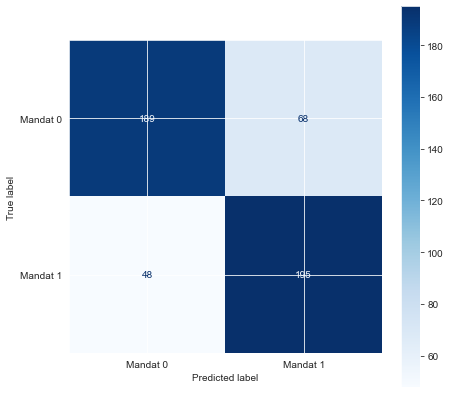

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
_, ax = plt.subplots(figsize=(7, 7))
svc_pred = results["SVC"]["model"].predict(X_test) # uložení predikcí modelu
svc_cm = confusion_matrix(y_test, svc_pred) # vytvoření matici záměn
svc_confm = ConfusionMatrixDisplay(confusion_matrix=svc_cm,
                                   display_labels=class_names) # vizualizace této matice
svc_confm.plot(ax=ax, cmap=plt.cm.Blues);

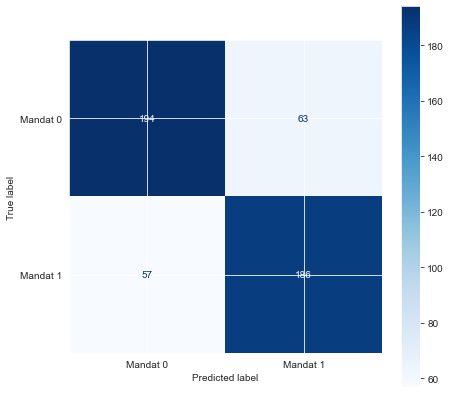

In [75]:
_, ax = plt.subplots(figsize=(7, 7))
randf_pred = results["Random Forest"]["model"].predict(X_test)
randf_cm = confusion_matrix(y_test, randf_pred)
randf_confm = ConfusionMatrixDisplay(confusion_matrix=randf_cm,
                                   display_labels=class_names)
randf_confm.plot(ax=ax, cmap=plt.cm.Blues);

Jak vidíme, matice jsou si velice podobné. Jenže True Positives Rate je větší u SVC modelu, než u Random Forest, což je pro naši klasifikaci lepší, jelikož chceme menší počet False Negatives. Stejně ale rozdíl je víceméně zanedbatelný.

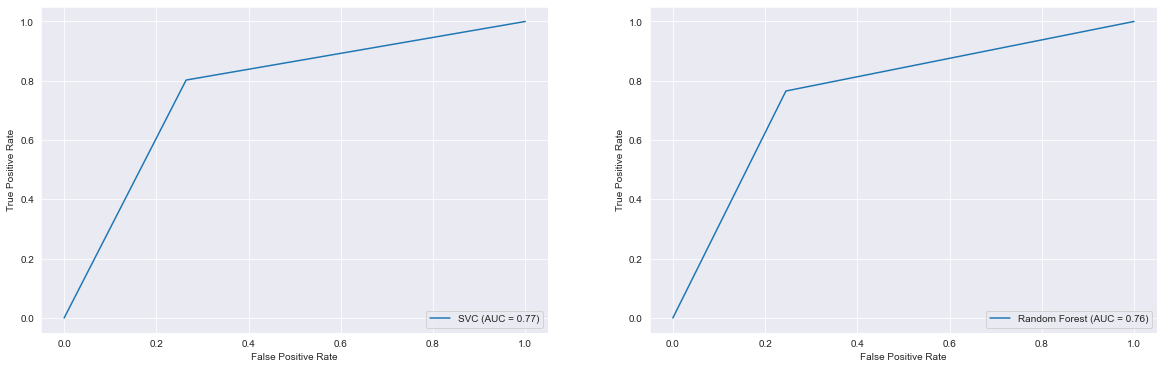

In [130]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))

svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_pred) # kalkulace False Positive Rate a True Positive Rate pro nakreslení ROC křivky
svc_auc = auc(svc_fpr, svc_tpr) # kalkulace plochy pod křivkou ROC
svc_roc = RocCurveDisplay(fpr=svc_fpr, tpr=svc_tpr, roc_auc=svc_auc) # vizualizace samotné křivky
svc_roc.plot(ax=ax1, name="SVC")

randf_fpr, randf_tpr, _ = roc_curve(y_test, randf_pred)
randf_auc = auc(randf_fpr, randf_tpr)
randf_roc = RocCurveDisplay(fpr=randf_fpr, tpr=randf_tpr, roc_auc=randf_auc)
randf_roc.plot(ax=ax2, name="Random Forest")
plt.show();

Plochy pod křivkou u obou modelů jsou si zase podobné. SVC dosáhl 0.77, Random Forest - 0.76.
Nakonec můžeme usoudit, že na daném datasetu SVC má lepší výsledky oproti Random Forest klasifikátoru, i když poslední má preprocessingové kroky.

## Závěr
* Při zpracování této práce přišli jsme k daným výsledkům:
    * Věkové rozložení kandidátů je symetrické, žádná věková skupina nepřevládá
    * Poměr muži:ženy je 2-2,5 ku 1 ve většině věkových skupin
    * Pravicová ideologie převládá u kandidátů, ale nakonec největší počet zvolených je ze středu
    * Nejčastěji do Poslanecké sněmovny kandidují zaměstnance ze soukromého sektoru, podnikatelé a politici.
    * Kandidáti bez vysokoškolského vzdělání mají větší tendenci být pravicovými, než kandidáti se daným stupněm vzdělání, kteří jsou většinou ve středu

Při trénování klasifikačního modelu byly porovnány dvě metodiky: Support Vector Machine Classifier bez preprocessingu a Random Forest Classifier s PCA preprocessingem. Originální dataset byl velice nevyvažený, proto byl použit undersampling. Hyperparametry obou modelů byly zvoleny pomocí Grid Search algoritmu metrikou AUC. Nakonec oba modely měli skoro stejné výsledky. Avšak SVC model nakonec dosáhl o 0,01 větší plochy pod křivkou a F-1 skóre -- 0.77.